In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.optimize as optimize

/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [60]:
import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import pycbcwaveform as pycbcwave
import plotparams


import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(pycbcwave)

import constants
imp.reload(constants)
from constants import *

# TaylorF2 waveform

In [ ]:
static void UNUSED
XLALSimInspiralPNPhasing_F2(
	PNPhasingSeries *pfa, /**< \todo UNDOCUMENTED */
	const REAL8 m1, /**< Mass of body 1, in Msol */
	const REAL8 m2, /**< Mass of body 2, in Msol */
	const REAL8 chi1L, /**< Component of dimensionless spin 1 along Lhat */
	const REAL8 chi2L, /**< Component of dimensionless spin 2 along Lhat */
	const REAL8 chi1sq,/**< Magnitude of dimensionless spin 1 */
	const REAL8 chi2sq, /**< Magnitude of dimensionless spin 2 */
	const REAL8 chi1dotchi2, /**< Dot product of dimensionles spin 1 and spin 2 */
	LALDict *p /**< LAL dictionary containing accessory parameters */
	)
{
    const REAL8 mtot = m1 + m2;
    const REAL8 d = (m1 - m2) / (m1 + m2);
    const REAL8 eta = m1*m2/mtot/mtot;
    const REAL8 m1M = m1/mtot;
    const REAL8 m2M = m2/mtot;
    /* Use the spin-orbit variables from arXiv:1303.7412, Eq. 3.9
     * We write dSigmaL for their (\delta m/m) * \Sigma_\ell
     * There's a division by mtotal^2 in both the energy and flux terms
     * We just absorb the division by mtotal^2 into SL and dSigmaL
     */
    const REAL8 SL = m1M*m1M*chi1L + m2M*m2M*chi2L;
    const REAL8 dSigmaL = d*(m2M*chi2L - m1M*chi1L);

    const REAL8 pfaN = 3.L/(128.L * eta);

    memset(pfa, 0, sizeof(PNPhasingSeries));

    /* Non-spin phasing terms - see arXiv:0907.0700, Eq. 3.18 */
    pfa->v[0] = 1.L;
    pfa->v[1] = 0.L;
    pfa->v[2] = 5.L*(743.L/84.L + 11.L * eta)/9.L;
    pfa->v[3] = -16.L*LAL_PI;
    pfa->v[4] = 5.L*(3058.673L/7.056L + 5429.L/7.L * eta
                     + 617.L * eta*eta)/72.L;
    pfa->v[5] = 5.L/9.L * (7729.L/84.L - 13.L * eta) * LAL_PI;
    pfa->vlogv[5] = 5.L/3.L * (7729.L/84.L - 13.L * eta) * LAL_PI;
    pfa->v[6] = (11583.231236531L/4.694215680L
                     - 640.L/3.L * LAL_PI * LAL_PI - 6848.L/21.L*LAL_GAMMA)
                 + eta * (-15737.765635L/3.048192L
                     + 2255./12. * LAL_PI * LAL_PI)
                 + eta*eta * 76055.L/1728.L
                 - eta*eta*eta * 127825.L/1296.L;
    pfa->v[6] += (-6848.L/21.L)*log(4.);
    pfa->vlogv[6] = -6848.L/21.L;
    pfa->v[7] = LAL_PI * ( 77096675.L/254016.L
                     + 378515.L/1512.L * eta - 74045.L/756.L * eta*eta);

    /* modify the PN coefficients if a non null LALSimInspiralTestGRParam structure is passed */
    pfa->v[0]*=(1.0+XLALSimInspiralWaveformParamsLookupNonGRDChi0(p));
    pfa->v[1] = XLALSimInspiralWaveformParamsLookupNonGRDChi1(p);
    pfa->v[2]*=(1.0+XLALSimInspiralWaveformParamsLookupNonGRDChi2(p));
    pfa->v[3]*=(1.0+XLALSimInspiralWaveformParamsLookupNonGRDChi3(p));
    pfa->v[4]*=(1.0+XLALSimInspiralWaveformParamsLookupNonGRDChi4(p));
    pfa->v[5]*=(1.0+XLALSimInspiralWaveformParamsLookupNonGRDChi5(p));
    pfa->vlogv[5]*=(1.0+XLALSimInspiralWaveformParamsLookupNonGRDChi5L(p));
    pfa->v[6]*=(1.0+XLALSimInspiralWaveformParamsLookupNonGRDChi6(p));
    pfa->vlogv[6]*=(1.0+XLALSimInspiralWaveformParamsLookupNonGRDChi6L(p));
    pfa->v[7]*=(1.0+XLALSimInspiralWaveformParamsLookupNonGRDChi7(p));
    REAL8 qm_def1=1.+XLALSimInspiralWaveformParamsLookupdQuadMon1(p);
    REAL8 qm_def2=1.+XLALSimInspiralWaveformParamsLookupdQuadMon2(p);
    
    /* Compute 2.0PN SS, QM, and self-spin */
    // See Eq. (6.24) in arXiv:0810.5336
    // 9b,c,d in arXiv:astro-ph/0504538
    REAL8 pn_sigma = eta * (721.L/48.L*chi1L*chi2L - 247.L/48.L*chi1dotchi2);
    pn_sigma += (720.L*qm_def1 - 1.L)/96.0L * m1M * m1M * chi1L * chi1L;
    pn_sigma += (720.L*qm_def2 - 1.L)/96.0L * m2M * m2M * chi2L * chi2L;
    pn_sigma -= (240.L*qm_def1 - 7.L)/96.0L * m1M * m1M * chi1sq;
    pn_sigma -= (240.L*qm_def2 - 7.L)/96.0L * m2M * m2M * chi2sq;

    REAL8 pn_ss3 =  (326.75L/1.12L + 557.5L/1.8L*eta)*eta*chi1L*chi2L;
    pn_ss3 += ((4703.5L/8.4L+2935.L/6.L*m1M-120.L*m1M*m1M)*qm_def1 + (-4108.25L/6.72L-108.5L/1.2L*m1M+125.5L/3.6L*m1M*m1M)) *m1M*m1M * chi1sq;
    pn_ss3 += ((4703.5L/8.4L+2935.L/6.L*m2M-120.L*m2M*m2M)*qm_def2 + (-4108.25L/6.72L-108.5L/1.2L*m2M+125.5L/3.6L*m2M*m2M)) *m2M*m2M * chi2sq;

    /* Spin-orbit terms - can be derived from arXiv:1303.7412, Eq. 3.15-16 */
    const REAL8 pn_gamma = (554345.L/1134.L + 110.L*eta/9.L)*SL + (13915.L/84.L - 10.L*eta/3.L)*dSigmaL;
    switch( XLALSimInspiralWaveformParamsLookupPNSpinOrder(p) )
    {
        case LAL_SIM_INSPIRAL_SPIN_ORDER_ALL:
        case LAL_SIM_INSPIRAL_SPIN_ORDER_35PN:
            pfa->v[7] += (-8980424995.L/762048.L + 6586595.L*eta/756.L - 305.L*eta*eta/36.L)*SL - (170978035.L/48384.L - 2876425.L*eta/672.L - 4735.L*eta*eta/144.L) * dSigmaL;
        case LAL_SIM_INSPIRAL_SPIN_ORDER_3PN:
            pfa->v[6] += LAL_PI * (3760.L*SL + 1490.L*dSigmaL)/3.L + pn_ss3;
        case LAL_SIM_INSPIRAL_SPIN_ORDER_25PN:
            pfa->v[5] += -1.L * pn_gamma;
            pfa->vlogv[5] += -3.L * pn_gamma;
        case LAL_SIM_INSPIRAL_SPIN_ORDER_2PN:
            pfa->v[4] += -10.L * pn_sigma;
        case LAL_SIM_INSPIRAL_SPIN_ORDER_15PN:
            pfa->v[3] += 188.L*SL/3.L + 25.L*dSigmaL;
        case LAL_SIM_INSPIRAL_SPIN_ORDER_1PN:
        case LAL_SIM_INSPIRAL_SPIN_ORDER_05PN:
        case LAL_SIM_INSPIRAL_SPIN_ORDER_0PN:
            break;
        default:
            XLALPrintError("XLAL Error - %s: Invalid spin PN order %i\n",
			   __func__, XLALSimInspiralWaveformParamsLookupPNSpinOrder(p) );
            XLAL_ERROR_VOID(XLAL_EINVAL);
            break;
    }

    /* At the very end, multiply everything in the series by pfaN */
    for(int ii = 0; ii <= PN_PHASING_SERIES_MAX_ORDER; ii++)
    {
        pfa->v[ii] *= pfaN;
        pfa->vlogv[ii] *= pfaN;
        pfa->vlogvsq[ii] *= pfaN;
    }
}


In [ ]:
REAL8 pn_sigma = eta * (721.L/48.L*chi1L*chi2L - 247.L/48.L*chi1dotchi2);
    pn_sigma += (720.L*qm_def1 - 1.L)/96.0L * m1M * m1M * chi1L * chi1L;
    pn_sigma += (720.L*qm_def2 - 1.L)/96.0L * m2M * m2M * chi2L * chi2L;
    pn_sigma -= (240.L*qm_def1 - 7.L)/96.0L * m1M * m1M * chi1sq;
    pn_sigma -= (240.L*qm_def2 - 7.L)/96.0L * m2M * m2M * chi2sq;

    REAL8 pn_ss3 =  (326.75L/1.12L + 557.5L/1.8L*eta)*eta*chi1L*chi2L;
    pn_ss3 += ((4703.5L/8.4L+2935.L/6.L*m1M-120.L*m1M*m1M)*qm_def1 + (-4108.25L/6.72L-108.5L/1.2L*m1M+125.5L/3.6L*m1M*m1M)) *m1M*m1M * chi1sq;
    pn_ss3 += ((4703.5L/8.4L+2935.L/6.L*m2M-120.L*m2M*m2M)*qm_def2 + (-4108.25L/6.72L-108.5L/1.2L*m2M+125.5L/3.6L*m2M*m2M)) *m2M*m2M * chi2sq;

    /* Spin-orbit terms - can be derived from arXiv:1303.7412, Eq. 3.15-16 */
    const REAL8 pn_gamma = (554345.L/1134.L + 110.L*eta/9.L)*SL + (13915.L/84.L - 10.L*eta/3.L)*dSigmaL;
    switch( XLALSimInspiralWaveformParamsLookupPNSpinOrder(p) )
    {
        case LAL_SIM_INSPIRAL_SPIN_ORDER_ALL:
        case LAL_SIM_INSPIRAL_SPIN_ORDER_35PN:
            pfa->v[7] += (-8980424995.L/762048.L + 6586595.L*eta/756.L - 305.L*eta*eta/36.L)*SL - (170978035.L/48384.L - 2876425.L*eta/672.L - 4735.L*eta*eta/144.L) * dSigmaL;
        case LAL_SIM_INSPIRAL_SPIN_ORDER_3PN:
            pfa->v[6] += LAL_PI * (3760.L*SL + 1490.L*dSigmaL)/3.L + pn_ss3;
        case LAL_SIM_INSPIRAL_SPIN_ORDER_25PN:
            pfa->v[5] += -1.L * pn_gamma;
            pfa->vlogv[5] += -3.L * pn_gamma;
        case LAL_SIM_INSPIRAL_SPIN_ORDER_2PN:
            pfa->v[4] += -10.L * pn_sigma;
        case LAL_SIM_INSPIRAL_SPIN_ORDER_15PN:
            pfa->v[3] += 188.L*SL/3.L + 25.L*dSigmaL;

In [29]:
def taylorf2_phase(mfreq, tbymc, phic, eta, chi1, chi2, lambda1, lambda2):
    """3.5PN point-particle phase.
    FFT sign convention is $\tilde h(f) = \int h(t) e^{-2 \pi i f t} dt$
    where $h(t) = h_+(t) + i h_\times(t)$.
    """
    delta = np.sqrt(1.0-4.0*eta)
    
    chis = 0.5*(chi1 + chi2)
    chia = 0.5*(chi1 - chi2)
    
    tlam = lamtilde_of_eta_lam1_lam2(eta, lambda1, lambda2)
    dtlam = deltalamtilde_of_eta_lam1_lam2(eta, lambda1, lambda2)
    
    beta = (113.0/12.0 - 19.0*eta/3.0)*chis + (113.0/12.0)*delta*chia
    
    sigma = eta*( (721.0/48.0)*(chis**2 - chia**2) - (247.0/48.0)*(chis**2 - chia**2) )\
    + (1.0 - 2.0*eta)*( (719.0/96.0)*(chis**2 + chia**2) - (233.0/96.0)*(chis**2 + chia**2) )\
    + delta*( (719.0/48.0)*(chis*chia) - (233.0/48.0)*(chis*chia) )
             
    gamma = (732985.0/2268.0 - 24260.0*eta/81.0 - 340.0*eta**2/9.0)*chis\
    + (732985.0/2268.0 + 140.0*eta/9.0)*delta*chia
    
    p6 = np.pi*( (2270.0/3.0)*delta*chia + (2270.0/3.0-520.0*eta)*chis )\
    + (75515.0/144.0 - 8225.0*eta/18.0)*delta*chis*chia\
    + (75515.0/288.0 - 263245.0*eta/252.0 - 480.0*eta**2)*chia**2\
    + (75515.0/288.0 - 232415.0*eta/504.0 + 1255.0*eta**2/9.0)*chis**2
    
    p7 = (-25150083775.0/3048192.0 + 26804935.0*eta/6040.0 - 1985.0*eta**2/48.0)*delta*chia\
    + (-25150083775.0/3048192.0 + 10566655595.0*eta/762048.0 - 1042165.0*eta**2/3024.0 + 5345.0*eta**3/36.0)*chis\
    + (14585.0/24.0 - 2380.0*eta)*delta*chia**3\
    + (14585.0/24.0 - 475.0*eta/6.0 + 100.0*eta**2/3.0)*chis**3\
    + (14585.0/8.0 - 215.0*eta/2.0)*delta*chia*chis**2\
    + (14585.0/8.0 - 7270.0*eta + 80.0*eta**2)*chia**2*chis
    
    p8 = np.pi*( (233915.0/168.0 - 99185.0*eta/252.0)*delta*chia\
                + (233915.0/168.0 - 3970375.0*eta/2268.0 + 19655.0*eta**2/189.0) )*chis
    
    # Calculate the coefficients once
    a00 = 3.0/(128.0*eta)
    
    a10 = 3715.0/756.0 + 55.0*eta/9.0
    
    a15 = -16.0*np.pi + 4*beta
    
    a20 = 15293365.0/508032.0 + (27145.0*eta)/504.0 + (3085.0*eta**2)/72.0 - 10*sigma
    
    a25 = (38645.0/756.0 - 65.0*eta/9)*np.pi - gamma
    
    a25ln = (3.0/2.0) * (38645.0/756.0 - (65.0*eta)/9.0)*np.pi
    
    a30 = 11583231236531.0/4694215680.0 - (6848.0*euler_gamma)/21.0 - (640.0*np.pi**2)/3.0 - 6848.0/63.0*np.log(64.0) \
    + (-15737765635.0/3048192.0 + (2255.0*np.pi**2)/12.0)*eta \
    + (76055.0*eta**2)/1728.0 \
    - (127825.0*eta**3)/1296.0 + p6
    
    a30ln = -(3.0/2.0) * 6848.0/63.0
    
    a35 = (77096675.0/254016.0 + (378515.0*eta)/1512.0 - (74045.0*eta**2)/756.0)*np.pi + p7
    
    a40 = p8
    
    a40ln = -(3.0/2.0)*p8
    
    a50 = -39.0*tlam/2.0
    
    a60 = -3115.0*tlam/64.0 + 6595.0*np.sqrt(1.0-4.0*eta)*dtlam/364.0
    
    # Now calculate phase for each freq
    x = (np.pi*mfreq)**(2.0/3.0)
    
    phi = -2.0*np.pi*mfreq*tbymc + phic + np.pi/4.0 \
    - a00*x**(-5.0/2.0)*(1.0 + a10*x + a15*x**1.5 + a20*x**2.0 \
                         + (a25+a25ln*np.log(x))*x**2.5 \
                         + (a30+a30ln*np.log(x))*x**3.0 \
                         + a35*x**3.5 \
                         + (a40+a40ln*np.log(x))*x**4.0 \
                         + a50*x**5 + a60*x**6)
    return phi

# Compare with LAL version

In [58]:
imp.reload(f2)

q, chi1, chi2, lambda1, lambda2 = 0.5, 0.9, 0.7, 5000, 100
mf_lower, mf_upper, delta_mf = 0.001, 0.05, 5.0e-7

# My TaylorF2 waveform
hf2 = f2.taylorf2(0.0, 0.0, q/(1+q)**2, chi1, chi2, lambda1, lambda2, mf_lower, mf_upper, delta_mf)
#hf2 = pycbcwave.dimensionless_fd_waveform(q, 0, 0, lambda1, lambda2, mf_lower, delta_mf, approximant='TaylorF2')

# PYCBC TaylorF2 waveform
hpycbcf2 = pycbcwave.dimensionless_fd_waveform(q, chi1, chi2, lambda1, lambda2, mf_lower, delta_mf, approximant='TaylorF2')

# # TaylorT4
# mf_lower, delta_tbym = 0.0009, 10.0
# length = 1.0e6
# mfon_end, mfoff_start, mfoff_end = 0.001, 0.015, 0.020
# mftrunc_start = mfon_end
# f_fitend = 0.002
# ht4 = conditioned_waveform(q, lambda1, lambda2, 
#                          mf_lower, delta_tbym, length, mfon_end, mfoff_start, mfoff_end, mftrunc_start,
#                         approximant='TaylorT4')
# ht4 = match_taylorf2_at_beginning(h, q, lambda1, lambda2, f_fitend)

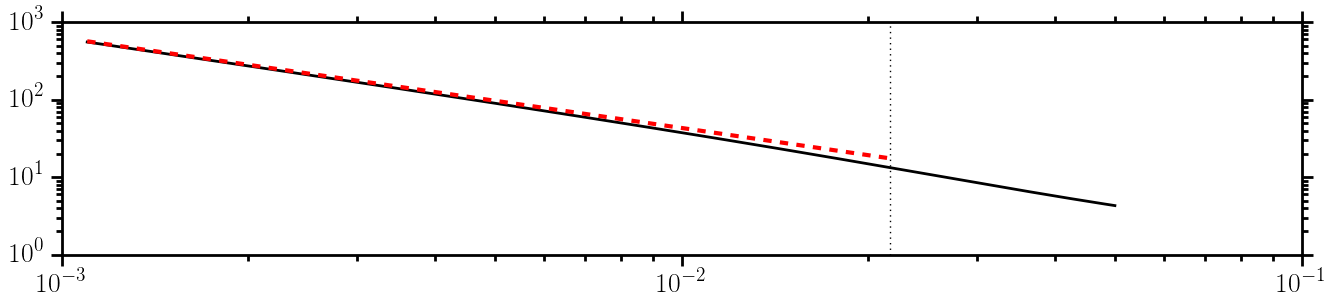

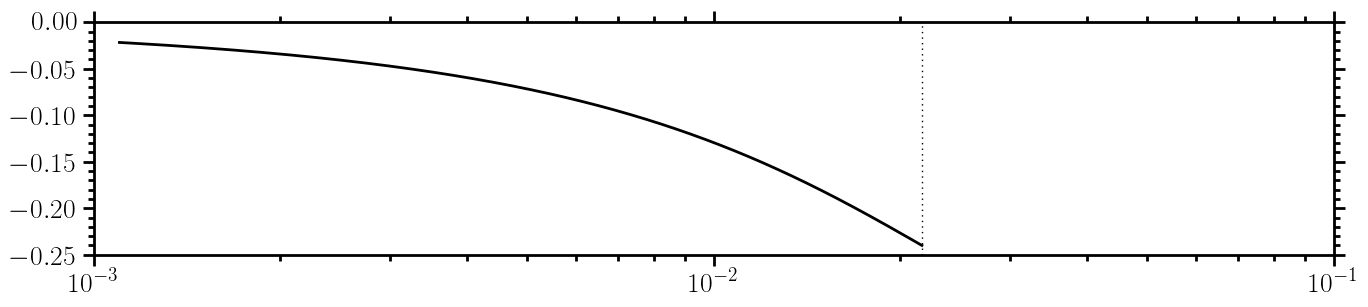

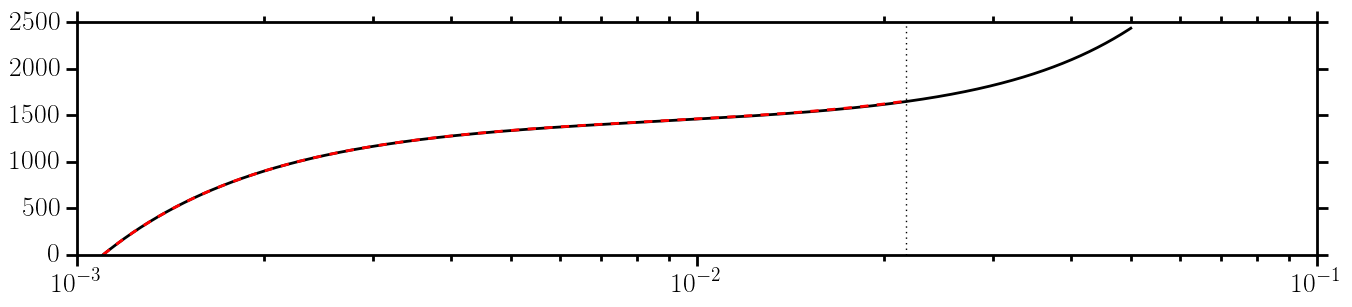

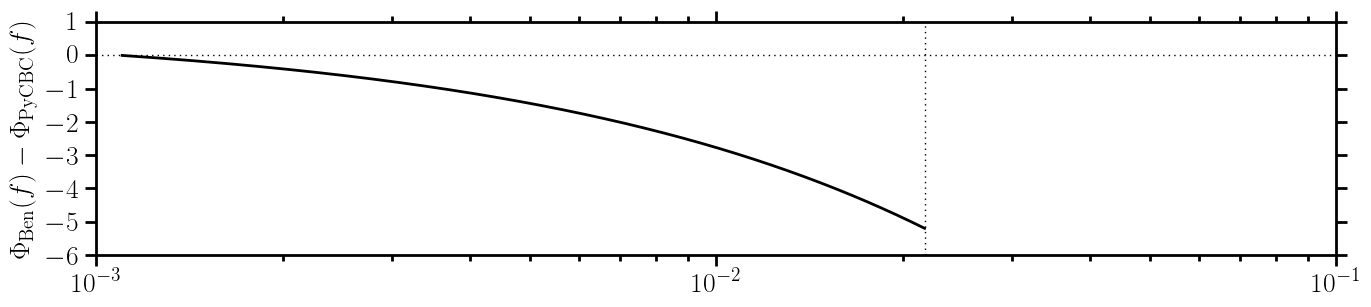

In [59]:
mf_start = 0.0011
hf2 = train.truncate_beginning(hf2, mf_start, remove_start_phase=True)
hpycbcf2 = train.truncate_beginning(hpycbcf2, mf_start, remove_start_phase=True)

# Phase difference
diff = wave.subtract_waveform_phase(hf2, hpycbcf2, npoints=10000, spacing='log')

# Fractional amplitude difference
amp_ratio = wave.waveform_amplitude_ratio(hf2, hpycbcf2, npoints=10000, spacing='log')


###### Amplitude ######
fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(hf2.x, hf2.amp, c='k', lw=2)
axes.plot(hpycbcf2.x, hpycbcf2.amp, c='r', lw=3, ls='--')
#axes.plot(ht4.x, ht4.amp, c='g', lw=3, ls=':')
axes.axvline(MF_ISCO, c='k', ls=':', lw=1)
axes.set_xscale('log')
axes.set_yscale('log')

fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(amp_ratio.x, amp_ratio.amp-1.0, c='k', lw=2)
axes.axvline(MF_ISCO, c='k', ls=':', lw=1)
axes.set_xscale('log')
#axes.set_yscale('log')
axes.minorticks_on()

####### Phase #######

fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(hf2.x, hf2.phase, c='k', lw=2)
axes.plot(hpycbcf2.x, hpycbcf2.phase, c='r', lw=2, ls='--')
axes.axvline(MF_ISCO, c='k', ls=':', lw=1)
axes.set_xscale('log')

fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(diff.x, diff.phase, c='k', lw=2)
axes.axhline(0.0, c='k', ls=':', lw=1)
axes.axvline(MF_ISCO, c='k', ls=':', lw=1)
axes.set_xscale('log')
axes.set_ylabel(r'$\Phi_{\rm Ben}(f)-\Phi_{\rm PyCBC}(f)$')
#axes.minorticks_on()
#axes.set_yscale('symlog', linthreshy=1.0)

# TaylorF2 stuff

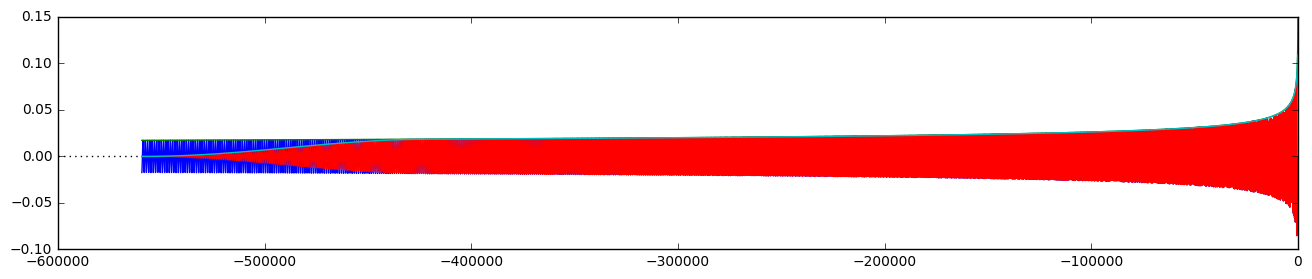

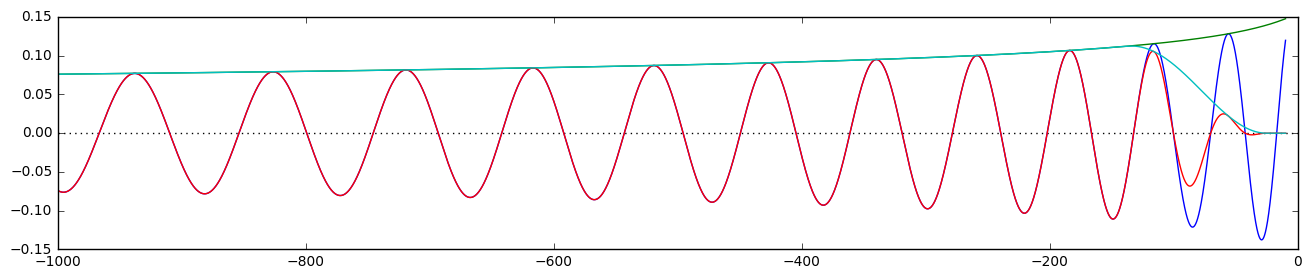

In [7]:
q, lambda1, lambda2 = 0.5, 0, 0
mf_lower, delta_tbym = 0.0009, 10.0
h = pycbcwave.dimensionless_td_waveform(q, lambda1, lambda2, mf_lower, delta_tbym, approximant='TaylorT4')
hwin = wave.window_waveform_in_frequency_interval(h, 0.001, 0.015, 0.020)

fig, axes = plt.subplots(1, figsize=(16, 3))
wave.plot_waveforms(axes, [h, hwin], npoints=10000)

fig, axes = plt.subplots(1, figsize=(16, 3))
wave.plot_waveforms(axes, [h, hwin], xi=-1000, npoints=10000)

In [11]:
p = np.array([1.0, 500, 500])

mf_lower, delta_tbym = 0.0009, 10.0
length = 2.0e6
mfon_end, mfoff_start, mfoff_end = 0.001, 0.015, 0.020
mftrunc_start = mfon_end
f_fitend = 0.002

h = train.conditioned_waveform(p[0], p[1], p[2], mf_lower, delta_tbym,
                         length, mfon_end, mfoff_start, mfoff_end, mftrunc_start)

h = train.match_taylorf2_at_beginning(h, p[0], p[1], p[2], f_fitend)

In [ ]:
mf_start = 0.0011
hf2 = truncate_beginning(hf2, mf_start, remove_start_phase=True)
hpycbcf2 = truncate_beginning(hpycbcf2, mf_start, remove_start_phase=True)

# Phase difference
diff = subtract_waveform_phase(hf2, hpycbcf2, npoints=10000, spacing='log')

# Fractional amplitude difference
amp_ratio = waveform_amplitude_ratio(hf2, hpycbcf2, npoints=10000, spacing='log')


###### Amplitude ######
fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(hf2.x, hf2.amp, c='k', lw=2)
axes.plot(hpycbcf2.x, hpycbcf2.amp, c='r', lw=3, ls='--')
axes.plot(ht4.x, ht4.amp, c='g', lw=3, ls=':')
axes.axvline(MF_ISCO, c='k', ls=':', lw=1)
axes.set_xscale('log')
axes.set_yscale('log')

fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(amp_ratio.x, amp_ratio.amp-1.0, c='k', lw=2)
axes.axvline(MF_ISCO, c='k', ls=':', lw=1)
axes.set_xscale('log')
#axes.set_yscale('log')
axes.minorticks_on()

####### Phase #######

fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(hf2.x, hf2.phase, c='k', lw=2)
axes.plot(hpycbcf2.x, hpycbcf2.phase, c='r', lw=2, ls='--')
axes.axvline(MF_ISCO, c='k', ls=':', lw=1)
axes.set_xscale('log')

fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(diff.x, diff.phase, c='k', lw=2)
axes.axhline(0.0, c='k', ls=':', lw=1)
axes.axvline(MF_ISCO, c='k', ls=':', lw=1)
axes.set_xscale('log')
axes.set_ylabel(r'$\Phi_{\rm Ben}(f)-\Phi_{\rm PyCBC}(f)$')
#axes.minorticks_on()
#axes.set_yscale('symlog', linthreshy=1.0)